In [1]:
import tools
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.signal import iirnotch, filtfilt, butter

F0 = 60.0  # Frequency to be removed from signal (Hz)
Q = 30.0  # Quality factor



In [2]:
def _bipolar_reference(data_arg):
    (n_time_samples, n_channels) = data_arg.shape
    # separate contact names
    leads = []
    contacts = []
    for i in data_arg.columns:
        if i in ['C3', 'C4', 'ECG1', 'ECG2']:
            n_channels = n_channels - 1
            continue

        M = re.match(r"(\D+)(\d+)", i)
        if M is None:
            n_channels = n_channels - 1
            continue
        leads.append(M.group(1).replace("EEG", "").strip())
        contacts.append(int(M.group(2)))

    leads_contacts = [f"{i}{j:02d}" for i, j in zip(leads, contacts)]
    col_names = []
    data_entries = []
    # find montage channel before
    for index in range(n_channels - 1):
        lead = leads[index]
        contact = contacts[index]

        next_lead_contact = f"{lead}{(contact + 1):02d}"

        try:
            next_index = leads_contacts.index(next_lead_contact)
        except ValueError:
            continue

        col_names.append(f"{leads_contacts[index]}-{leads_contacts[next_index]}")
        data_entries.append(data_arg.iloc[:, index] - data_arg.iloc[:, next_index])
    
    data_entries = np.array(data_entries).T
    bipolar_data = pd.DataFrame(data_entries, columns=col_names, index=data_arg.index)

    return bipolar_data


In [3]:
# username = 'pattnaik'
# pwd_bin_file = '/mnt/local/gdrive/public/USERS/pattnaik/pre-ictal-similarity/code/pat_ieeglogin.bin'

username = 'igvilla'
pwd_bin_file = '/gdrive/public/USERS/igvilla/igv_ieeglogin.bin'

###

# practice of a random new time:
# start_time_sec = 315961
# end_time_sec = 315961 + 60 

# practice of a random new time:
# iEEG_filename = 'HUP231_phaseII'
# start_time_usec = start_time_sec * 1e6
# end_time_usec = end_time_sec * 1e6

# practice of a random new time:
# iEEG_filename = 'HUP231_phaseII'
# start_time_usec = start_time_sec * 1e6
# end_time_usec = end_time_sec * 1e6

### 

# LB3_001_phaseII, seizure 1:
start_time_sec = 159762.33385 - 60 # showing starting 1 minute before the seizure
end_time_sec = 159762.33385 + 78.8561500000068

# LB3_001_phaseII, seizure 1:
iEEG_filename = 'HUP227_phaseII_D01'
start_time_usec = start_time_sec * 1e6
end_time_usec = end_time_sec * 1e6




In [4]:
data, fs = tools.get_iEEG_data(username, pwd_bin_file, iEEG_filename, start_time_usec, end_time_usec, select_electrodes=np.arange(50))



In [5]:
start_time_usec, end_time_usec

(159702333850.0, 159841190000.0)

In [6]:
# extract dims
(n_samples, n_channels) = data.shape

# set time array
t_sec = np.linspace(start_time_sec, end_time_sec, n_samples)

# remove 60Hz noise
b, a = iirnotch(F0, Q, fs)
signal_filt = filtfilt(b, a, data, axis=0)

# bandpass between 1 and 120Hz
bandpass_b, bandpass_a = butter(3, [1, 120], btype='bandpass', fs=fs)
signal_filt = filtfilt(bandpass_b, bandpass_a, signal_filt, axis=0)

# format resulting data into pandas DataFrame
signal_filt = pd.DataFrame(signal_filt, columns=data.columns)
signal_filt.index = pd.to_timedelta(t_sec, unit="S")

signal_ref = _bipolar_reference(signal_filt)

In [7]:
np.size(signal_ref)

5687560

In [8]:
signal_ref

,EKG01-EKG02,LL01-LL02,LL02-LL03,LL03-LL04,LL04-LL05,LL05-LL06,LL06-LL07,LL07-LL08,LL08-LL09,LL09-LL10,...,RL08-RL09,RL09-RL10,RL10-RL11,RL11-RL12,RM01-RM02,RM02-RM03,RM03-RM04,RM04-RM05,RM05-RM06,RM06-RM07
1 days 20:21:42.333850,4.832134,-145.208640,142.567564,-2.153176,-2.824357,-1.498018,5.013212,-2.373430,6.955989,5.218388,...,-2.326774,13.305226,1.344321,-6.098911,1.600378,-0.474512,-0.321268,-0.315154,-1.945661,-5.037010
1 days 20:21:42.334826567,5.559863,-249.911897,249.411160,-3.488500,-1.821042,-2.573649,7.407487,-3.053966,8.747891,3.803260,...,-2.891615,14.338522,-0.567536,-5.496188,-0.575163,-0.865774,-0.388708,0.012362,-1.185275,-4.636572
1 days 20:21:42.335803135,5.817788,-356.378622,357.491743,-4.605590,-1.140488,-4.010028,9.593421,-3.148637,10.416372,3.162947,...,-3.127500,14.754662,-2.204457,-5.052088,-2.175786,-1.193530,-0.459797,0.211687,-0.137575,-4.645980
1 days 20:21:42.336779702,5.337934,-458.279474,460.070077,-5.306556,-1.027545,-6.048714,11.477813,-2.317613,11.916388,3.717074,...,-2.906473,14.248480,-3.359041,-4.873225,-2.880774,-1.392306,-0.571313,0.224234,1.560466,-5.356136
1 days 20:21:42.337756269,4.162250,-541.615387,542.983993,-5.461887,-1.546165,-8.750106,13.150156,-0.622831,13.279607,5.383813,...,-2.370139,12.941729,-3.933909,-4.982683,-2.720797,-1.432463,-0.762470,0.076258,4.323564,-6.876811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1 days 20:24:01.186093731,-12.182192,335.200988,-356.773015,21.598413,5.446056,6.775781,0.016344,-3.853240,5.111246,-3.638090,...,-2.181870,-6.226253,-2.833884,-0.248802,-6.109155,2.578271,3.109777,-0.578764,-8.710840,4.266096
1 days 20:24:01.187070298,-9.320089,331.089249,-347.147275,16.796388,5.017140,6.398782,-0.038296,-3.668970,4.892302,-3.690355,...,-1.825872,-6.083892,-2.586821,-0.264753,-5.608365,2.513746,3.128658,-0.870819,-8.911509,4.064879
1 days 20:24:01.188046865,-6.456417,287.259345,-301.480125,15.133484,4.371085,5.889196,-0.291290,-3.225315,4.473569,-3.550414,...,-1.663843,-5.787963,-2.384146,-0.299830,-4.482099,2.326351,2.794380,-1.031232,-8.088636,3.953752
1 days 20:24:01.189023433,-4.265044,193.863072,-210.532022,16.973773,3.571595,5.270558,-0.776625,-2.516790,3.863408,-3.163203,...,-1.768388,-5.282526,-2.256635,-0.345108,-2.798052,2.028406,2.068962,-0.971252,-6.113029,3.850479


In [9]:
signal_ref.to_hdf(f"../data/eeg_pt-{iEEG_filename}_start-{start_time_sec}_end-{end_time_sec}.h5", key='ieeg')

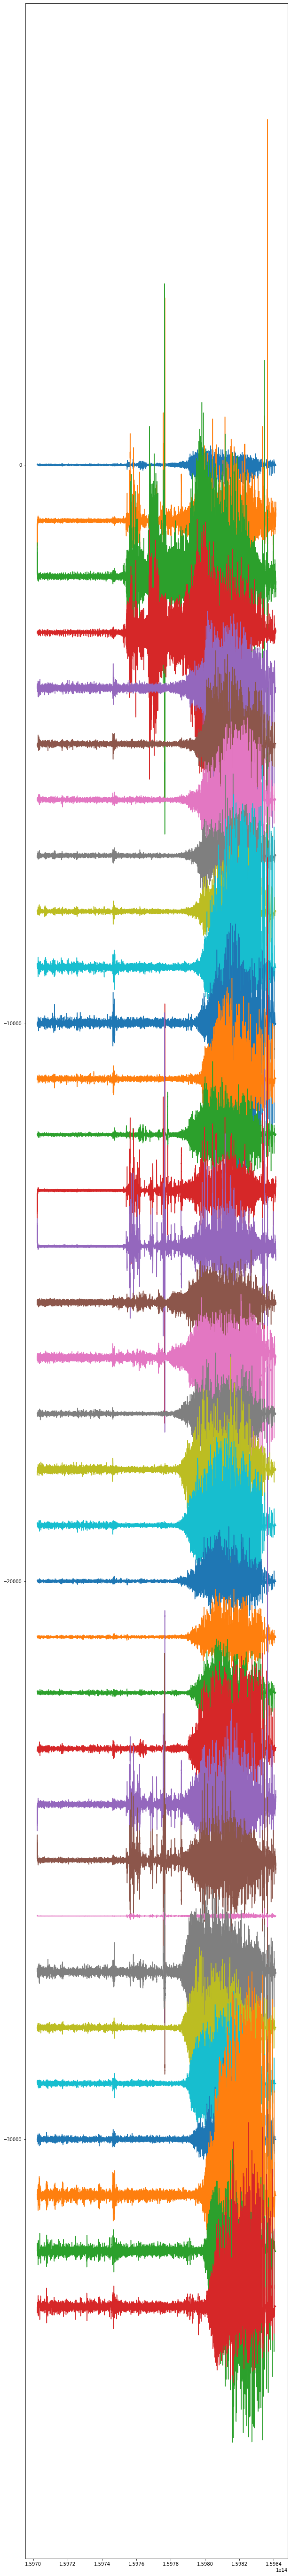

In [10]:
plt.figure(figsize=(10, 100)); plt.plot(signal_ref.iloc[:, 0:34] + np.arange(34)*-1000)